In [1]:
using RCall
R"
require(tidyverse)
require(lubridate)
require(ggpubr)
require(ggpmisc)
"
figsize = (;width,height) -> RCall.ijulia_setdevice(MIME("image/svg+xml"), width=width, height=height)

┌ Warning: RCall.jl: Loading required package: tidyverse
│ ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
│ ✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
│ ✔ tibble  3.1.8      ✔ dplyr   1.0.10
│ ✔ tidyr   1.2.1      ✔ stringr 1.5.0 
│ ✔ readr   2.1.3      ✔ forcats 0.5.2 
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: Loading required package: lubridate
│ Loading required package: timechange
│ 
│ Attaching package: ‘lubridate’
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     date, intersect, setdiff, union
│ 
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: Loading required package: ggpubr
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: Loading required package: ggpmisc
│ Loading required package: gg

#1 (generic function with 1 method)

Prepare MathJax
$$
\def\R{{\cal R}}
\def\d{{\rm d}}
$$

In [2]:
R"
# https://www.niid.go.jp/niid/ja/calendar/9261-idwr-calendar-2020.html
yw2date = data.frame(date = full_seq(ym(c(201001, 205001)), period=1)) %>%
    mutate(
        year = isoyear(date),
        week = isoweek(date),
    ) %>%
    group_by(year,week) %>%
    summarise_all(last) %>%
    ungroup
"

RObject{VecSxp}
# A tibble: 2,088 × 3
    year  week date      
   <dbl> <dbl> <date>    
 1  2009    53 2010-01-03
 2  2010     1 2010-01-10
 3  2010     2 2010-01-17
 4  2010     3 2010-01-24
 5  2010     4 2010-01-31
 6  2010     5 2010-02-07
 7  2010     6 2010-02-14
 8  2010     7 2010-02-21
 9  2010     8 2010-02-28
10  2010     9 2010-03-07
# … with 2,078 more rows


# Effective reproduction number $\R_e$ of flu in Japan

In [3]:
R"""
# https://www.nature.com/articles/s41598-019-39057-w
flu.mean = 2.6
flu.var = 1.5^2

# https://www.niid.go.jp/niid/ja/data.html
flu.weekly = read_csv('japan-flu-per-sentinel-weekly.csv') %>%
    { colnames(.)[1] = 'year'; . } %>%
    mutate(
        across(where(is.character), ~ str_extract(., '[+-]?\\d+') %>% as.numeric)
    ) %>%
    pivot_longer(!year, names_to='week', values_to='p') %>%
    mutate(
        year = 2000 + year,
        week = str_extract(week, '\\d+') %>% as.numeric,
        r = ifelse(p == 0 | lag(p) == 0, NA, (p/lag(p))^(1/7) - 1),
        Re = (1+r*flu.var/flu.mean)^(flu.mean^2/flu.var)
    ) %>% 
    left_join(yw2date, by=c('year', 'week')) %>%
    mutate(
        month = month(date)
    ) %>%
    filter(!is.na(month))
"""

┌ Warning: RCall.jl: New names:
│ • `` -> `...1`
│ Rows: 11 Columns: 54
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: ","
│ chr  (4): ...1, 32週, 34週, 36週
│ dbl (50): 1週, 2週, 3週, 4週, 5週, 6週, 7週, 8週, 9週, 10週, 11週, 12週, 13週, 14週, 15週, ...
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


RObject{VecSxp}
# A tibble: 574 × 7
    year  week     p        r     Re date       month
   <dbl> <dbl> <dbl>    <dbl>  <dbl> <date>     <dbl>
 1  2013     1  3.91 NA       NA     2013-01-06     1
 2  2013     2 12.1   0.175    1.53  2013-01-13     1
 3  2013     3 22.6   0.0936   1.26  2013-01-20     1
 4  2013     4 36.4   0.0708   1.20  2013-01-27     1
 5  2013     5 35.8  -0.00245  0.994 2013-02-03     2
 6  2013     6 26.7  -0.0411   0.897 2013-02-10     2
 7  2013     7 16.3  -0.0680   0.833 2013-02-17     2
 8  2013     8 13.9  -0.0226   0.942 2013-02-24     2
 9  2013     9 12.3  -0.0178   0.954 2013-03-03     3
10  2013    10 10.4  -0.0236   0.940 2013-03-10     3
# … with 564 more rows


┌ Warning: RCall.jl: Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ `geom_smooth()` using formula = 'y ~ x'
│ Warning: Removed 153 rows containing non-finite values (`stat_smooth()`).
│ Warning: Removed 54 rows containing missing values (`geom_point()`).
│ `geom_smooth()` using formula = 'y ~ x'
│ Warning: Removed 192 rows containing non-finite values (`stat_smooth()`).
│ Warning: Removed 192 rows containing missing values (`geom_point()`).
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


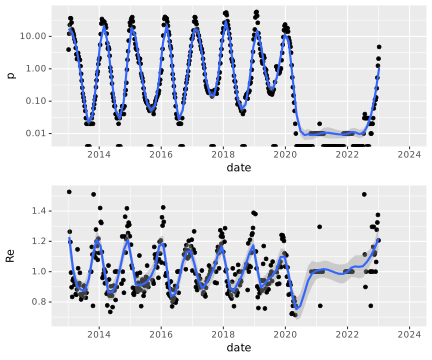

RObject{VecSxp}


In [4]:
figsize(width=6, height=5)
R"""
ggarrange(
    flu.weekly %>%
    ggplot(aes(date, p)) +
        geom_point() +
        geom_smooth(method='loess', span=52/nrow(flu.weekly)) +
        scale_y_log10(),
    flu.weekly %>%
    ggplot(aes(date, Re)) +
        geom_point() +
        geom_smooth(method='loess', span=52/nrow(flu.weekly)),
    ncol=1,
    align='v'
)
"""

┌ Warning: RCall.jl: Warning: Removed 48 rows containing non-finite values (`stat_ydensity()`).
│ Warning: Removed 48 rows containing missing values (`geom_point()`).
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


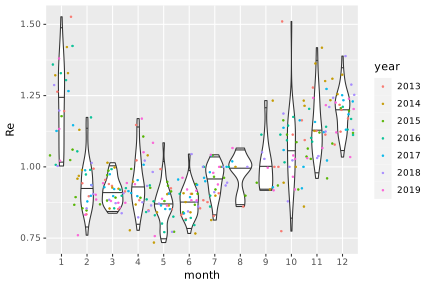

RObject{VecSxp}


In [5]:
figsize(width=6, height=4)
R"""
flu.weekly %>%
    filter(year < 2020) %>%
    mutate(
        month = factor(month),
        year = factor(year)
    ) %>%
ggplot(aes(month, Re)) +
    geom_violin(draw_quantiles=c(.025, .5, .975)) +
    geom_jitter(aes(color=year), size=.5, width=.5)
"""

In [6]:
flu_Re_monthly = R"""
flu.weekly %>%
    filter(year < 2020) %>%
    mutate(month = month %>% as.integer) %>%
    group_by(month) %>%
    summarize(Re=mean(Re, na.rm=TRUE)) %>%
    write_csv('flu-Re-monthly.csv')
""" |> rcopy

Row,month,Re
,Int64,Float64
1,1,1.22257
2,2,0.934111
3,3,0.913335
4,4,0.944047
5,5,0.871005
6,6,0.878739
7,7,0.952765
8,8,0.977842
9,9,1.00557


# Immunity factor $\lambda$
With heterogeneic susceptibility of population, 
epidemic dynamic differs from simple compartment model.
We use [Tkachenko et al.](https://www.pnas.org/doi/10.1073/pnas.2015972118) as 
$$
\def\d{{\,\rm d}}
\def\D#1#2{\frac{\d #1}{\d #2}}
\def\<{\left<}
\def\>{\right>}
\def\[{\left[}
\def\]{\right]}
\def\E{{\mathbb E}}
\def\V{{\mathbb V}}
\begin{align}
\D{S_a}{t} & = - \beta a S_a J = - j_a \\
J & = \int \R_a \int^t K(s) j_a(t-s)  \d s f(a) \d a \\
& = \<\R_a \[K, j_a\]\> \\
& = \[K, \R_e J\]
\end{align}
$$
where
- susceptibility $a \sim f(a)$, 
- susceptible population rate $S_a(t)$ with susceptibility $a$,
- infectivity $\R_a$ of sub-population $S_a$,
- force of infection $J(t)$,
- generation interval distribution $K(s)$, and
- effective reproduction number $\R_e(t) = \beta \<a \R_a S_a(t)\>$.

Since we want to estiamte weekly/monthly reproduction number,
the variation of $\R_e$ can be assumed to be negligible over generation interval, say
$$
J = \[K, \R_e J\] = \R_e \[K, J\].
$$
This gives us the well-known result to calculate $\R_e$ :
$$
\R_e(t) = \frac{1}{M_K(-r(t))}
$$
where moment generating function $M_K$ of $K$ and instantaneous growth rate $r(t) = \d/\d t \log(J(t))$. Now we have two-ways to calculate $\R_e$ by using $f(a)$ and $K(s)$, and both are supposed to be equal: 
$$
\beta \<a \R_a S_a(t)\> = \frac{1}{M_K(-r(t))}.
$$

If we assume 
$\chi \in \[0,1\]$,
$\R_a = a^\chi$,
$f(a) \sim \Gamma({\rm shape}=k, {\rm scale}=1/k)$, and
$K(s) \sim \Gamma({\rm mean}=\E\[s\], {\rm var}=\V\[s\])$,
there is closed form as 
$$
\R_0 S(t)^\lambda = (1+r(t)\theta)^{\E\[s\] / \theta} = \R_e(t)
$$
where 
- immunity factor $\lambda = 1 + (1+\chi)/k$,
- basic reproduction number $\R_0 = \beta (1+1/k)$,
- susceptible population rate $S = \<S_a\>$, and
- scale paramter $\theta = \V\[s\] / \E\[s\]$ of $K$.

Now immunity factor $\lambda$(and $\R_0$) can be estimated by fitting linear regression $\log(\R_e) \sim \log(S)$.

In [7]:
R"""
flu.total = read_csv("japan-flu-total-per-season.csv") %>%
    separate(from, c('from.year', 'from.week'), convert=TRUE) %>%
    separate(to, c('to.year', 'to.week'), convert=TRUE) %>%
    mutate(
        from.yw = from.year * 100 + from.week,
        to.yw = to.year * 100 + to.week
    )
"""

┌ Warning: RCall.jl: Rows: 10 Columns: 3
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: ","
│ chr (2): from, to
│ num (1): total
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


RObject{VecSxp}
# A tibble: 10 × 7
   from.year from.week to.year to.week    total from.yw  to.yw
       <int>     <int>   <int>   <int>    <dbl>   <dbl>  <dbl>
 1      2020        36    2021      17    14000  202036 202117
 2      2019        36    2020      17  7289000  201936 202017
 3      2018        36    2019      17 12000000  201836 201917
 4      2017        36    2018      17 14843400  201736 201817
 5      2016        36    2017      20 11193600  201636 201720
 6      2015        36    2016      20 10645800  201536 201620
 7      2014        36    2015      20  9919800  201436 201520
 8      2013        36    2014      21 10375200  201336 201421
 9      2012        36    2013      21  9042000  201236 201321
10      2011        36    2012      18 10876800  201136 201218


In [8]:
R"""
flu.combined = c()
for(i in 1:nrow(flu.total)) {
    row = flu.total[i,]
    flu.weekly %>%
        mutate(yw = year*100+week) %>%
        filter(row$from.yw <= yw & yw <= row$to.yw) %>%
        mutate(
            n = p/sum(p, na.rm=TRUE)*row$total,
            season = i
        ) %>%
        { flu.combined <<- rbind(flu.combined, .) }
}
flu.combined = flu.combined %>%
    group_by(season) %>%
    mutate(
        S = 1-cumsum(replace_na(n,0))/126e6
    ) %>%
    ungroup()
"""

RObject{VecSxp}
# A tibble: 308 × 11
    year  week     p     r    Re date       month     yw     n season     S
   <dbl> <dbl> <dbl> <dbl> <dbl> <date>     <dbl>  <dbl> <dbl>  <int> <dbl>
 1  2020    36  0       NA    NA 2020-09-06     9 202036    0       1  1   
 2  2020    37  0       NA    NA 2020-09-13     9 202037    0       1  1   
 3  2020    38  0       NA    NA 2020-09-20     9 202038    0       1  1   
 4  2020    39  0       NA    NA 2020-09-27     9 202039    0       1  1   
 5  2020    40  0       NA    NA 2020-10-04    10 202040    0       1  1   
 6  2020    41  0       NA    NA 2020-10-11    10 202041    0       1  1   
 7  2020    42  0       NA    NA 2020-10-18    10 202042    0       1  1   
 8  2020    43  0.01    NA    NA 2020-10-25    10 202043  667.      1  1.00
 9  2020    44  0.01     0     1 2020-11-01    11 202044  667.      1  1.00
10  2020    45  0       NA    NA 2020-11-08    11 202045    0       1  1.00
# … with 298 more rows


┌ Warning: RCall.jl: Warning: Transformation introduced infinite values in continuous y-axis
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


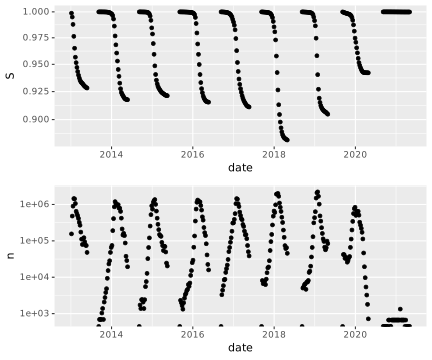

RObject{VecSxp}


In [9]:
figsize(width=6, height=5)
R"""
ggarrange(
    ggplot(flu.combined) +
        geom_point(aes(date, S)) +
        scale_y_log10(),
    ggplot(flu.combined) +
        geom_point(aes(date, n)) +
        scale_y_log10(),
    ncol=1,
    align='v'
)
"""

┌ Warning: RCall.jl: Warning: Removed 39 rows containing non-finite values (`stat_poly_line()`).
│ Warning: Removed 39 rows containing non-finite values (`stat_poly_eq()`).
│ Warning: Removed 39 rows containing missing values (`geom_point()`).
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


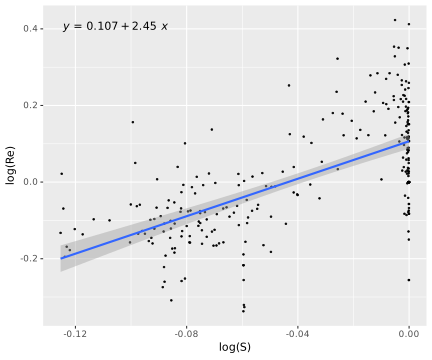

RObject{VecSxp}


In [10]:
R"""
flu.combined %>%
ggplot(aes(log(S), log(Re))) +
    geom_point(size=.5) +
    stat_poly_line(method='lm') +
    stat_poly_eq(method='lm', aes(label=after_stat(eq.label)))
"""

┌ Warning: RCall.jl: Warning: Removed 5 rows containing non-finite values (`stat_poly_line()`).
│ Warning: Removed 5 rows containing non-finite values (`stat_poly_eq()`).
│ Warning: Removed 5 rows containing missing values (`geom_point()`).
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


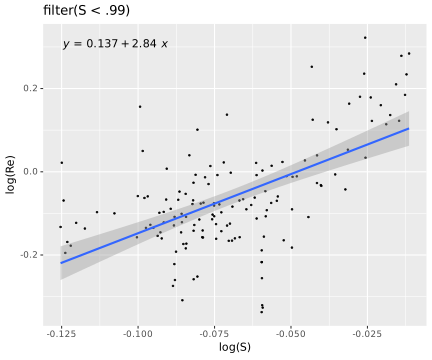

RObject{VecSxp}


In [11]:
R"""
flu.combined %>%
    filter(S < .99) %>%
ggplot(aes(log(S), log(Re))) +
    geom_point(size=.5) +
    stat_poly_line(method='lm') +
    stat_poly_eq(method='lm', aes(label=after_stat(eq.label))) +
    labs(title = 'filter(S < .99)')
"""

┌ Warning: RCall.jl: `geom_smooth()` using formula = 'y ~ x'
│ Warning: Removed 39 rows containing non-finite values (`stat_smooth()`).
│ Warning: Removed 39 rows containing missing values (`geom_point()`).
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


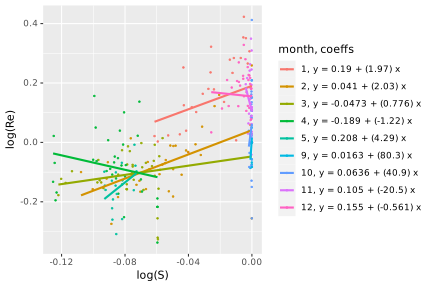

RObject{VecSxp}


In [12]:
figsize(width=6, height=4)
R"""
flu.combined %>%
    group_by(month) %>%
    mutate(
        label = {
            m = lm(log(Re) ~ log(S), data = cur_data())
            coef = m$coefficients
            label = str_interp('${month[1]}, y = ${signif(coef[1],3)} + (${signif(coef[2],3)}) x')
            factor(label, levels = str_sort(unique(label), numeric=TRUE))
        }
    ) %>%
ggplot(aes(log(S), log(Re), color=label)) +
    geom_point(size=.5) +
    geom_smooth(method='lm', se=FALSE) +
    labs(color='month, coeffs')
"""